# Explainable AI con algoritmi genetici

## Naive implementation

Si mette il focus su problemi di classificazione o, per essere più precisi,
sui classificatori stessi.

Non è infatti di nostro interesse se la classificazione sia corretta o meno,
ci interessa sapere:

- "Perché" i dati sono stati classificati in quel modo.
- Come modificare i dati in modo che varino il meno possibile ma vengano
  classificati in modo differente.

L'esempio più banale che può venirci in mente è un problema di classificazione
in cui ogni punto ha due sole feature e due possibili classi. Andiamo quindi a
generare un dataset con queste caratteristiche e alleniamo classificatore.


<Figure size 640x480 with 0 Axes>

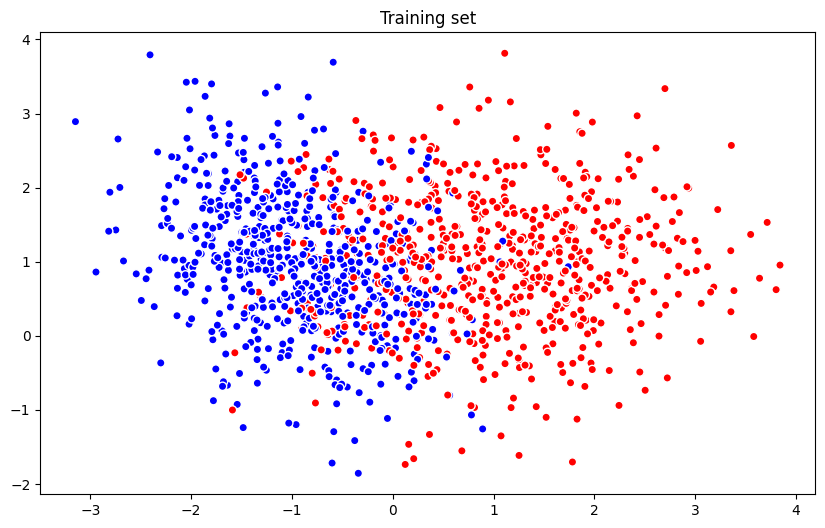

In [24]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


X, y = make_classification(
    n_samples=1500,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=1,
    shuffle=True,
    random_state=0,
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=250, train_size=1250
)

train_coords = X_train.T

plt.set_cmap("bwr")
plt.figure(figsize=(10, 6))
plt.title("Training set")
plt.scatter(train_coords[0], train_coords[1], c=y_train, ec="w")
plt.show()

Abbiamo quindi generato un training set e un test set su cui allenare e testare
il modello rispettivamente.

In realtà a noi non interessa per il momento testare la correttezza del modello
ma solo usare dati non presenti in fase di training per ciò che andremo a fare
dopo.

Proseguiamo quindi con l'allenamento del modello e la classificazione dei nuovi
punti i quali diventeranno il dataset di riferimento.


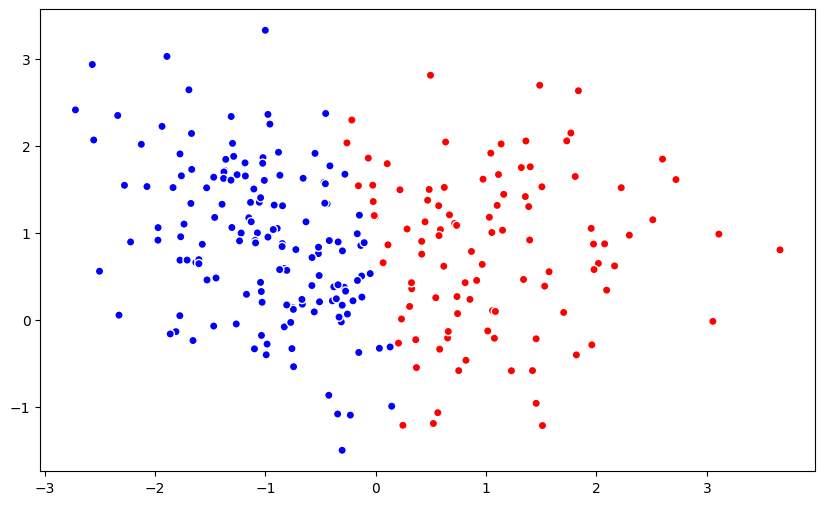

In [25]:
from sklearn.neural_network import MLPClassifier

import warnings

warnings.filterwarnings("ignore")

classifier = MLPClassifier(max_iter=2000)
classifier.fit(X_train, y_train)
y_predicted = classifier.predict(X_test)

test_coords = X_test.T

plt.figure(figsize=(10, 6))
plt.scatter(test_coords[0], test_coords[1], c=y_predicted, ec="w")
plt.show()

A questo punto prendiamo a caso uno dei punti classificati, di seguito
evidenziato in verde


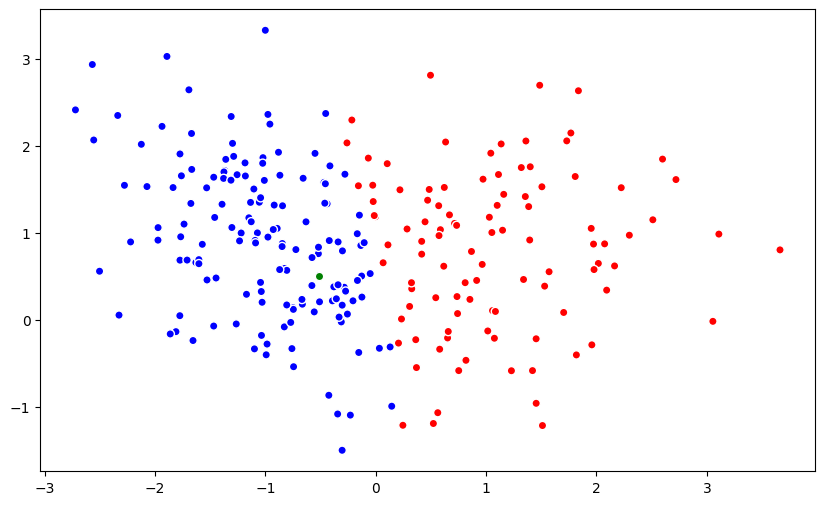

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(test_coords[0], test_coords[1], c=y_predicted, ec="w")

point = X_test[0]
point_class = y_predicted[0]

plt.scatter(point[0], point[1], c="g", ec="w")
plt.show()

e proseguiamo con la fase di explaining tramite un algoritmo genetico.


## Algoritmo genetico

L'algoritmo genetico prevede di analizzare ogni singolo punto un numero di
volte pari al numero delle classi possibili (nel nostro caso 2).

Andremo a definire due approcci volti a risolvere due problemi differenti:

1. spiegare perché quel punto è stato classificato in un
   determinato modo.
2. il secondo per capire come modificare le feature di quel punto il meno
   possibile per riuscire a classificarlo in tutte le altre possibili classi.

Nel nostro caso abbiamo una sola possibile altra classe ma nel caso ne avessimo
di più il metodo sarebbe lo stesso, basta cambiare la classe target di arrivo.

### Struttura del cromosoma

Prima di passare alla generazione della popolazione definiamo che forma
dovrebbe avere il cromosoma.

Dato che in entrambe le casistiche che vogliamo analizzare abbiamo bisogno di
sapere le feature di ogni individuo ma abbiamo anche bisogno di sapere come è
stato classificato il modo più naturale è quello di avere una coppia formata
da un vettore di feature e da un valore che indica la sua classe. Nel nostro
caso un numpy array e un numero intero rispettivamente.

### Generazione della popolazione iniziale

Come in ogni algoritmo genetico c'è bisogno di andare a generare una
popolazione iniziale. Nel nostro caso abbiamo bisogno che la popolazione
iniziale sia generata in modo che i nuovi individui siano simili a quello di
riferimento.

Per riuscire a generare una popolazione con queste caratteristiche possiamo
sfruttare la deviazione standard di ogni feature per generare un offset
verosimile con il dataset che stiamo considerando.


In [27]:
std_dev = X_train.std(axis=0)
std_dev

array([1.33530285, 0.9071165 ])

Per generare punti sintetici intorno a quello di riferimento usiamo valori
compresi tra $-\frac{1}{2}$ e $+\frac{1}{2}$ della deviazione standard, di
modo che il punto di riferimento sia centrato intorno alla nuova popolazione.

Andiamo quindi a definire la funzione di generazione di un cromosoma, iniziamo
a definire l'algoritmo genetico e generiamo una popolazione iniziale.


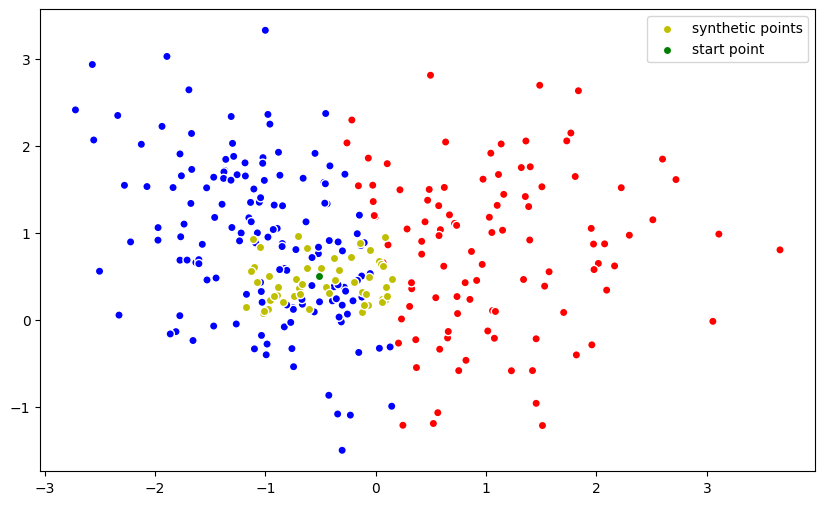

In [28]:
import numpy as np
from numpy import random as rnd
from ppga import base


# Generazione di un singolo cromosoma
def generate(point, std_dev):
    return [point + rnd.uniform(-std_dev / 2, std_dev / 2, size=(2,)), 0]


toolbox = base.ToolBox()
toolbox.set_generation(generate, point=point, std_dev=std_dev)

# generazione di una popolazione composta da 50 individui
population = toolbox.generate(50)
synth_points = np.array([i.chromosome[0] for i in population])

plt.figure(figsize=(10, 6))
plt.scatter(test_coords[0], test_coords[1], c=y_predicted, ec="w")
plt.scatter(
    synth_points.T[0], synth_points.T[1], c="y", ec="w", label="synthetic points"
)
plt.scatter(point[0], point[1], c="g", ec="w", label="start point")

plt.legend()
plt.show()

Come possiamo vedere gli individui sintetici generati si dispongono intorno
al punto di partenza considerato.

### Funzione di valutazione

L'altro parametro da definire correttamente è la funzione di valutazione del
valore di fitness di ciascun individuo.

In particolare dovremo definire due funzioni differenti:

1. Una che premia gli individui simili e classificati allo stesso modo di
   quello di riferimento.
2. L'altra che premia invece gli individui simili a quello di riferimento ma
   classificati in una certa classe target differente da quella dell'individuo
   di riferimento.

In realtà se ne potrebbe scrivere una sola che prende come parametro la classe
target.

Iniziamo con il definire la prima. Al momento abbiamo una popolazione di
individui sintetici non classificati. Per i nostri scopi abbiamo bisogno di
valutare due parametri:

1. Vedere se l'individuo sintetico è classificato come quello di riferimento.
2. Valutare quanto i due individui sono simili (o diversi).

Per il primo punto abbiamo bisogno del classificatore usato in precedenza,
mentre per il secondo punto possiamo usare la distanza euclidea per valutare
la distanza tra le varie feature.


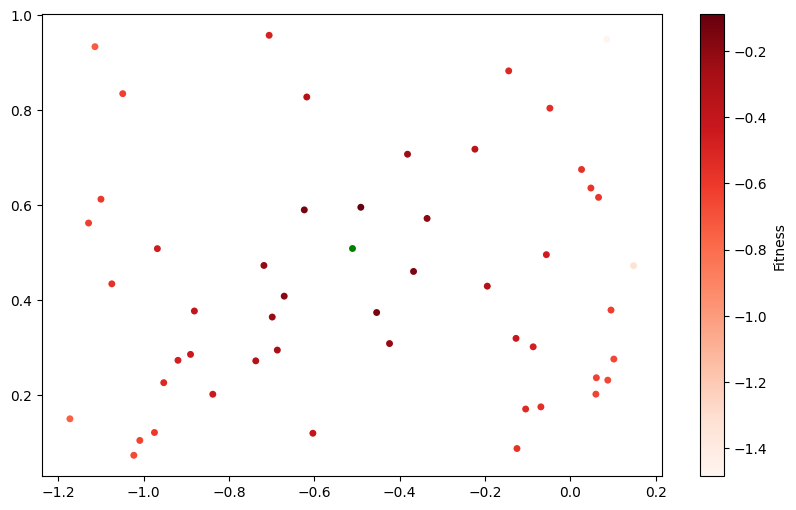

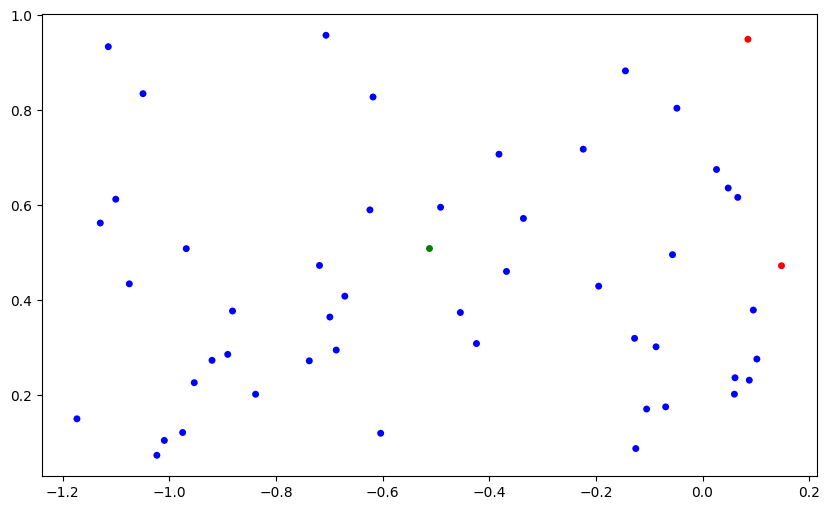

In [39]:
from numpy import linalg as la


def evaluate(chromosome, point, target_class, classifier):
    # classification
    features, _ = chromosome
    features = features.reshape(1, -1)
    chromosome[1] = classifier.predict(features)

    # feature distance
    distance = la.norm(point - features, ord=2)

    if target_class == chromosome[1]:
        return (distance,)
    else:
        return (distance * 2,)


toolbox.set_weights((-1.0,))
toolbox.set_evaluation(evaluate, point, point_class, classifier)
pop = list(map(toolbox.evaluate, population))

fitness_values = [i.fitness for i in pop]
plt.figure(figsize=(10, 6))
sc = plt.scatter(
    synth_points.T[0],
    synth_points.T[1],
    c=fitness_values,
    ec="w",
    cmap=plt.get_cmap("Reds"),
)
plt.colorbar(sc, label="Fitness")
plt.scatter(X_test.T[0][0], X_test.T[1][0], c="g", ec="w")
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(
    synth_points.T[0],
    synth_points.T[1],
    c=[i.chromosome[1] for i in pop],
    ec="w",
)
plt.scatter(X_test.T[0][0], X_test.T[1][0], c="g", ec="w")
plt.show()

Come possiamo vedere da questo piccolo test ad ogni punto viene assegnato un
valore di fitness inversamente proporzionale alla sua distanza dal punto di
riferimento.

Da notare però che i punti classificati diversamente, nonostante siano ad una
distanza dal punto di riferimento che è simile agli altri, vengono penalizzati
con una fitness più bassa.


### Stessa classe

Nel caso in cui si voglia capire come mai un certo individuo sia stato
classificiato in un certo modo, si fa evolvere la popolazione andando ad
attribuire

- Fitness più alta agli individui vicini a quello di partenza e che sono
  classificati allo stesso modo.
- Fitness più bassa ma comunque positiva ai fini dell'evoluzione per quegli
  individui più lontani ma comunque classificati allo stesso modo. In questo
  modo è possibile esplorare meglio lo spazio entro cui le feature possono
  variare senza che l'individuo venga classificato diversamente.
- Fitness bassa agli individui troppo diversi da quello di partenza.
- Fitness molto bassa o invalida a quelli che vengono classificati in modo
  diverso da quello di partenza.

In fase di valutazione di un individuo lo si deve per prima cosa classificare
e poi si va a calcolare la distanza dall'individuo di partenza.

Se l'individuo di partenza si trova molto vicino al confine tra una classe e
l'altra potrebbe succedere che si generi un individuo sintetico molto vicino
ma classificato in modo diverso. Ecco che diventa necessario studiare bene la
funzione di fitness di modo che si abbia una grossa penalità o che si invalidi
direttamente la fitness in questo caso.

### Cambio di classe

Nel caso in cui invece si voglia capire come modificare le feature per cambiare
la classe dell'individuo, si determina la classe obbiettivo e si cerca di
generare una popolazione la quale si evolve di modo da avvicinarsi il più
velocemente possibile a tale classe.

La funzione di fitness è dunque molto simile alla precedente ma usata in modo
quasi inverso.

- Gli individui con fitness più alta sono quelli che rimangono vicino a quello
  di partenza ma che riescono a cambiare classe.
- Quelli con fitness più bassa sono quelli che non riescono a cambiare classe
  e/o che sono troppo diversi dall'individuo di partenza.

Nel caso in cui si abbiamo più classi si ripete il procedimento per ognuna di
esse.
